# 01

In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"
# ROOT_PROJECT = "/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/"
# ROOT_DATASET = "/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling"
#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader import ImageSuperResolution


In [ ]:
import itertools
import collections
import numpy as np
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.profiler import profile, record_function, ProfilerActivity
# torch.set_default_dtype(torch.float64)

from einops import rearrange


class CustomLayerNorm(nn.Module):
    def __init__(self, nchannels):
        super(CustomLayerNorm, self).__init__()
        
        self.nchannels = nchannels
        self.weighted_transform = nn.Conv2d(nchannels, nchannels, kernel_size=1, stride=1, groups=nchannels, bias=False)

    def forward(self, x):
        # bz, nchannels, h, w = x.shape
        sigma = x.var(dim=1, keepdim=True, correction=1)
        # bz, 1, h, w = sigma.shape
        return self.weighted_transform(x / torch.sqrt(sigma+1e-5))
    


##########################################################################
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FeedForward, self).__init__()

        hidden_features = int(dim*ffn_expansion_factor)
        # hidden_features = dim

        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=bias)

        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = nn.functional.gelu(x1) * x2
        x = self.project_out(x)
        return x


##########################################################################
class FFBlock(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FFBlock, self).__init__()

        self.norm = CustomLayerNorm(dim)

        self.skip_connect_weight_final = Parameter(
            torch.ones((2), dtype=torch.float32) * torch.tensor([0.5, 0.5]),
            requires_grad=True
        )
        self.ffn = FeedForward(dim, ffn_expansion_factor, bias)

    def forward(self, x):
        x = self.skip_connect_weight_final[0]*x + self.skip_connect_weight_final[1]*self.ffn(self.norm(x))

        return x



##########################################################################
## Overlapped image patch embedding with 3x3 Conv
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c=3, embed_dim=48, bias=False):
        super(OverlapPatchEmbed, self).__init__()

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, x):
        x = self.proj(x)

        return x



##########################################################################
## Resizing modules
class Downsample(nn.Module):
    def __init__(self, n_feat):
        super(Downsample, self).__init__()

        # self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat//2, kernel_size=3, stride=1, padding=1, bias=False),
        #                           nn.PixelUnshuffle(2))

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat//4, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelUnshuffle(2))
        
        # self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat, kernel_size=3, stride=2, padding=1, padding_mode="replicate", bias=False))

    def forward(self, x):
        return self.body(x)

class Upsample(nn.Module):
    def __init__(self, n_feat):
        super(Upsample, self).__init__()

        # self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat*2, kernel_size=3, stride=1, padding=1, bias=False),
        #                           nn.PixelShuffle(2))
        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat*4, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelShuffle(2))

        # self.body = nn.Sequential(nn.ConvTranspose2d(n_feat, n_feat, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False))


    def forward(self, x):
        return self.body(x)

##########################################################################
class FeatureExtraction(nn.Module):
    def __init__(self, 
        inp_channels=3, 
        out_channels=48, 
        dim = 48,
        num_blocks = [2,2,2,2], 
        num_refinement_blocks = 4,
        ffn_expansion_factor = 2.0,
        bias = False,
    ):

        super(FeatureExtraction, self).__init__()

        self.patch_embed = OverlapPatchEmbed(inp_channels, dim)

        self.encoder_level1 = nn.Sequential(*[FFBlock(dim=dim, ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[0])])
        
        self.down1_2 = Downsample(dim) ## From Level 1 to Level 2
        self.encoder_level2 = nn.Sequential(*[FFBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[1])])
        
        self.down2_3 = Downsample(int(dim)) ## From Level 2 to Level 3
        self.encoder_level3 = nn.Sequential(*[FFBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[2])])

        self.down3_4 = Downsample(int(dim)) ## From Level 3 to Level 4
        self.latent = nn.Sequential(*[FFBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[3])])
        
        self.up4_3 = Upsample(int(dim)) ## From Level 4 to Level 3
        self.reduce_chan_level3 = nn.Conv2d(int(dim*2), int(dim), kernel_size=1, bias=bias)
        self.decoder_level3 = nn.Sequential(*[FFBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[2])])

        self.up3_2 = Upsample(int(dim)) ## From Level 3 to Level 2
        self.reduce_chan_level2 = nn.Conv2d(int(dim*2), int(dim), kernel_size=1, bias=bias)
        self.decoder_level2 = nn.Sequential(*[FFBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[1])])
        
        self.up2_1 = Upsample(int(dim))  ## From Level 2 to Level 1  (NO 1x1 conv to reduce channels)

        self.decoder_level1 = nn.Sequential(*[FFBlock(dim=int(dim*2), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[0])])
        
        self.refinement = nn.Sequential(*[FFBlock(dim=int(dim*2), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_refinement_blocks)])

        ###########################
        self.output = nn.Conv2d(int(dim*2), out_channels, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, inp_img):

        inp_enc_level1 = self.patch_embed(inp_img)
        out_enc_level1 = self.encoder_level1(inp_enc_level1)
        
        inp_enc_level2 = self.down1_2(out_enc_level1)
        out_enc_level2 = self.encoder_level2(inp_enc_level2)

        inp_enc_level3 = self.down2_3(out_enc_level2)
        out_enc_level3 = self.encoder_level3(inp_enc_level3) 

        inp_enc_level4 = self.down3_4(out_enc_level3)        
        latent = self.latent(inp_enc_level4) 
                        
        inp_dec_level3 = self.up4_3(latent)
        inp_dec_level3 = torch.cat([inp_dec_level3, out_enc_level3], 1)
        inp_dec_level3 = self.reduce_chan_level3(inp_dec_level3)
        out_dec_level3 = self.decoder_level3(inp_dec_level3) 

        inp_dec_level2 = self.up3_2(out_dec_level3)
        inp_dec_level2 = torch.cat([inp_dec_level2, out_enc_level2], 1)
        inp_dec_level2 = self.reduce_chan_level2(inp_dec_level2)
        out_dec_level2 = self.decoder_level2(inp_dec_level2) 

        inp_dec_level1 = self.up2_1(out_dec_level2)
        inp_dec_level1 = torch.cat([inp_dec_level1, out_enc_level1], 1)
        out_dec_level1 = self.decoder_level1(inp_dec_level1)
        
        out_dec_level1 = self.refinement(out_dec_level1)
        out_dec_level1 = self.output(out_dec_level1)

        # return [latent, out_dec_level3, out_dec_level2, out_dec_level1]
        return [out_dec_level1]


class GLRFast(nn.Module):
    def __init__(self, 
            n_channels, n_node_fts, n_graphs, connection_window, device, M_diag_init=0.4
        ):
        super(GLRFast, self).__init__()

        self.device = device
        self.n_channels        = n_channels
        self.n_node_fts        = n_node_fts
        self.n_graphs          = n_graphs
        self.n_edges           = (connection_window == 1).sum()
        self.connection_window = connection_window
        self.buffer_size       = connection_window.sum()

        # edges type from connection_window
        window_size = connection_window.shape[0]
        connection_window = connection_window.reshape((-1))
        m = np.arange(window_size)-window_size//2
        edge_delta = np.array(
            list(itertools.product(m, m)),
            dtype=np.int32
        )
        self.edge_delta = edge_delta[connection_window == 1]
        
        self.pad_dim_hw = np.abs(self.edge_delta.min(axis=0))


        ### Trainable parameters
        # features on nodes #self.n_node_fts
        self.multiM = Parameter(
            torch.ones((self.n_graphs, self.n_node_fts), device=self.device, dtype=torch.float32)*M_diag_init,
            requires_grad=True,
        )


    def get_neighbors_pixels(self, img_features):
        _, _, H, W = img_features.shape
        padH, padW = self.pad_dim_hw
        img_features_frame = nn.functional.pad(img_features, (padW, padW, padH, padH), "replicate")
        neighbors_pixels = []
        for shift_h, shift_w in self.edge_delta:
            fromh = padH + shift_h
            toh = padH + shift_h + H
            fromw = padW + shift_w
            tow = padW + shift_w + W
            
            neighbors_pixels.append(
                img_features_frame[:, :, fromh:toh, fromw:tow]
            )
        neighbors_pixels_features = torch.stack(neighbors_pixels, axis=-3)

        return neighbors_pixels_features
    

    def normalize_and_transform_features(self, img_features):
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape
        # img_features = img_features.view(batch_size, self.n_graphs, self.n_node_fts, h_size, w_size)
        img_features = torch.nn.functional.normalize(img_features, dim=2)

        img_features_transform = torch.einsum(
            "bhcHW, hc -> bhcHW", img_features, self.multiM
        )
    
        img_features_transform = img_features_transform.view(batch_size, self.n_graphs*self.n_node_fts, h_size, w_size)

        return img_features_transform


    def extract_edge_weights(self, img_features):
        
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape

        img_features = self.normalize_and_transform_features(img_features)
        img_features_neighbors = self.get_neighbors_pixels(img_features)

        features_similarity = (img_features[:, :, None, :, :] * img_features_neighbors)
        features_similarity = features_similarity.view(
            batch_size, self.n_graphs, self.n_node_fts, self.n_edges, h_size, w_size
        ).sum(axis=2)

        edge_weights_norm = nn.functional.softmax(features_similarity, dim=2) 
        node_degree = edge_weights_norm.sum(axis=2)

        return edge_weights_norm, node_degree
    


    def op_L_norm(self, img_signals, edge_weights, node_degree):

        batch_size, n_graphs, n_channels, h_size, w_size = img_signals.shape
        img_features_neighbors = self.get_neighbors_pixels(
            img_signals.view(batch_size, n_graphs*n_channels, h_size, w_size)
        ).view(batch_size, n_graphs, n_channels, self.n_edges, h_size, w_size)
        Wx = torch.einsum(
            "bhceHW, bheHW -> bhcHW", img_features_neighbors, edge_weights
        )
        output = img_signals - Wx
        return output

    def forward(self, patchs, edge_weights, node_degree):
        output_patchs = self.op_L_norm(patchs, edge_weights, node_degree)
        return output_patchs
    



class GTVFast(nn.Module):
    def __init__(self, 
            n_channels, n_node_fts, n_graphs, connection_window, device, M_diag_init=0.4
        ):
        super(GTVFast, self).__init__()

        self.device = device
        self.n_channels        = n_channels
        self.n_node_fts        = n_node_fts
        self.n_graphs          = n_graphs
        self.n_edges           = (connection_window == 1).sum()
        self.connection_window = connection_window
        self.buffer_size       = connection_window.sum()

        # edges type from connection_window
        window_size = connection_window.shape[0]
        connection_window = connection_window.reshape((-1))
        m = np.arange(window_size)-window_size//2
        edge_delta = np.array(
            list(itertools.product(m, m)),
            dtype=np.int32
        )
        self.edge_delta = edge_delta[connection_window == 1]
        
        self.pad_dim_hw = np.abs(self.edge_delta.min(axis=0))


        ### Trainable parameters
        # features on nodes #self.n_node_fts
        self.multiM = Parameter(
            torch.ones((self.n_graphs, self.n_node_fts), device=self.device, dtype=torch.float32)*M_diag_init,
            requires_grad=True,
        )


    def get_neighbors_pixels(self, img_features):
        _, _, H, W = img_features.shape
        padH, padW = self.pad_dim_hw
        img_features_frame = nn.functional.pad(img_features, (padW, padW, padH, padH), "replicate")
        # neighbors_pixels = []
        # for shift_h, shift_w in self.edge_delta:
        #     fromh = padH + shift_h
        #     toh = padH + shift_h + H
        #     fromw = padW + shift_w
        #     tow = padW + shift_w + W
            
        #     neighbors_pixels.append(
        #         img_features_frame[:, :, fromh:toh, fromw:tow]
        #     )
        # neighbors_pixels_features = torch.stack(neighbors_pixels, axis=-3)
        neighbors_pixels_features = torch.stack([
            img_features_frame[:, :, padH + self.edge_delta[0, 0]:padH + self.edge_delta[0, 0] + H, padW + self.edge_delta[0, 1]:padW + self.edge_delta[0, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[1, 0]:padH + self.edge_delta[1, 0] + H, padW + self.edge_delta[1, 1]:padW + self.edge_delta[1, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[2, 0]:padH + self.edge_delta[2, 0] + H, padW + self.edge_delta[2, 1]:padW + self.edge_delta[2, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[3, 0]:padH + self.edge_delta[3, 0] + H, padW + self.edge_delta[3, 1]:padW + self.edge_delta[3, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[4, 0]:padH + self.edge_delta[4, 0] + H, padW + self.edge_delta[4, 1]:padW + self.edge_delta[4, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[5, 0]:padH + self.edge_delta[5, 0] + H, padW + self.edge_delta[5, 1]:padW + self.edge_delta[5, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[6, 0]:padH + self.edge_delta[6, 0] + H, padW + self.edge_delta[6, 1]:padW + self.edge_delta[6, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[7, 0]:padH + self.edge_delta[7, 0] + H, padW + self.edge_delta[7, 1]:padW + self.edge_delta[7, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[8, 0]:padH + self.edge_delta[8, 0] + H, padW + self.edge_delta[8, 1]:padW + self.edge_delta[8, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[9, 0]:padH + self.edge_delta[9, 0] + H, padW + self.edge_delta[9, 1]:padW + self.edge_delta[9, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[10, 0]:padH + self.edge_delta[10, 0] + H, padW + self.edge_delta[10, 1]:padW + self.edge_delta[10, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[11, 0]:padH + self.edge_delta[11, 0] + H, padW + self.edge_delta[11, 1]:padW + self.edge_delta[11, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[12, 0]:padH + self.edge_delta[12, 0] + H, padW + self.edge_delta[12, 1]:padW + self.edge_delta[12, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[13, 0]:padH + self.edge_delta[13, 0] + H, padW + self.edge_delta[13, 1]:padW + self.edge_delta[13, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[14, 0]:padH + self.edge_delta[14, 0] + H, padW + self.edge_delta[14, 1]:padW + self.edge_delta[14, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[15, 0]:padH + self.edge_delta[15, 0] + H, padW + self.edge_delta[15, 1]:padW + self.edge_delta[15, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[16, 0]:padH + self.edge_delta[16, 0] + H, padW + self.edge_delta[16, 1]:padW + self.edge_delta[16, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[17, 0]:padH + self.edge_delta[17, 0] + H, padW + self.edge_delta[17, 1]:padW + self.edge_delta[17, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[18, 0]:padH + self.edge_delta[18, 0] + H, padW + self.edge_delta[18, 1]:padW + self.edge_delta[18, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[19, 0]:padH + self.edge_delta[19, 0] + H, padW + self.edge_delta[19, 1]:padW + self.edge_delta[19, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[20, 0]:padH + self.edge_delta[20, 0] + H, padW + self.edge_delta[20, 1]:padW + self.edge_delta[20, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[21, 0]:padH + self.edge_delta[21, 0] + H, padW + self.edge_delta[21, 1]:padW + self.edge_delta[21, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[22, 0]:padH + self.edge_delta[22, 0] + H, padW + self.edge_delta[22, 1]:padW + self.edge_delta[22, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[23, 0]:padH + self.edge_delta[23, 0] + H, padW + self.edge_delta[23, 1]:padW + self.edge_delta[23, 1] + W]
        ], axis=-3)
        
        return neighbors_pixels_features
    

    def normalize_and_transform_features(self, img_features):
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape
        # img_features = img_features.view(batch_size, self.n_graphs, self.n_node_fts, h_size, w_size)
        img_features = torch.nn.functional.normalize(img_features, dim=2)

        img_features_transform = torch.einsum(
            "bhcHW, hc -> bhcHW", img_features, self.multiM
        )
    
        img_features_transform = img_features_transform.view(batch_size, self.n_graphs*self.n_node_fts, h_size, w_size)

        return img_features_transform


    def extract_edge_weights(self, img_features):
        
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape

        img_features = self.normalize_and_transform_features(img_features)
        img_features_neighbors = self.get_neighbors_pixels(img_features)

        features_similarity = (img_features[:, :, None, :, :] * img_features_neighbors)
        features_similarity = features_similarity.view(
            batch_size, self.n_graphs, self.n_node_fts, self.n_edges, h_size, w_size
        ).sum(axis=2)

        edge_weights_norm = nn.functional.softmax(features_similarity, dim=2) 
        node_degree = edge_weights_norm.sum(axis=2)

        return edge_weights_norm, node_degree

    def op_C(self, img_signals, edge_weights, node_degree):


        batch_size, n_graphs, n_channels, h_size, w_size = img_signals.shape
        # img_signals = self.stats_conv(img_signals)

        img_features_neighbors = self.get_neighbors_pixels(
            img_signals.view(batch_size, n_graphs*n_channels, h_size, w_size)
        ).view(batch_size, n_graphs, n_channels, self.n_edges, h_size, w_size)
        Cx1 = img_signals[:, :, :, None, :, :] * edge_weights[:, :, None, :, :, :]
        Cx2 = img_features_neighbors * edge_weights[:, :, None, :, :, :]
        
        output = Cx1 - Cx2

        return output
    
    def op_C_transpose(self, edge_signals, edge_weights, node_degree):

        batch_size, n_graphs, n_channels, n_edges, H, W = edge_signals.shape
        edge_signals = edge_signals * edge_weights[:, :, None, :, :, :]

        output = edge_signals.sum(axis=3)

        padH, padW = self.pad_dim_hw
        output = nn.functional.pad(
            output.view(batch_size, n_graphs*n_channels, H, W),
            (padW, padW, padH, padH), "replicate"
        ).view(batch_size, n_graphs, n_channels, H + 2*padH, W + 2*padW)

        i=0
        for shift_h, shift_w in self.edge_delta:
            fromh = padH + shift_h
            toh = padH + shift_h + H
            fromw = padW + shift_w
            tow = padW + shift_w + W
            
            output[:, :, :, fromh:toh, fromw:tow] = output[:, :, :, fromh:toh, fromw:tow] - edge_signals[:, :, :, i, :, :]
            i+=1

        output = output[:, :, :, padH:-padH, padW:-padW]

        # output = self.stats_conv_transpose(output)
        return output

    def forward(self, patchs, edge_weights, node_degree):
        # C^T C
        edges_signals = self.op_C(patchs, edge_weights, node_degree)
        output_patchs = self.op_C_transpose(edges_signals, edge_weights, node_degree)

        return output_patchs


#########################################################################
class DCestimator(nn.Module):
    def __init__(self, dim_in, dim_out, hidden_features):
        super(DCestimator, self).__init__()

        self.project_in = nn.Conv2d(dim_in, hidden_features*2, kernel_size=1, bias=False)
        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=False)
        self.project_out = nn.Conv2d(hidden_features, dim_out, kernel_size=1, bias=False)

    def forward(self, patchs):

        out = self.project_in(patchs)
        out01, out02 = self.dwconv(out).chunk(2, dim=1)
        out = nn.functional.gelu(out01) * out02
        out = self.project_out(out)
        return out
    

class MixtureGTV(nn.Module):
    def __init__(self, 
            nchannels_in,
            n_graphs,
            n_node_fts,
            n_cnn_fts,
            connection_window,
            n_cgd_iters,
            alpha_init,
            beta_init,
            muy_init, ro_init, gamma_init,
            device
        ):
        super(MixtureGTV, self).__init__()

        self.device       = device
        self.n_graphs     = n_graphs
        self.n_node_fts   = n_node_fts
        self.n_total_fts  = n_graphs * n_node_fts
        self.n_cnn_fts    = n_cnn_fts
        self.n_levels     = 4
        self.n_cgd_iters  = n_cgd_iters
        self.nchannels_in = nchannels_in
        self.connection_window = connection_window

        self.alphaCGD =  Parameter(
            torch.ones((self.n_cgd_iters, n_graphs), device=self.device, dtype=torch.float32) * alpha_init,
            requires_grad=True
        )

        self.betaCGD =  Parameter(
            torch.ones((self.n_cgd_iters, n_graphs), device=self.device, dtype=torch.float32) * beta_init,
            requires_grad=True
        )

        self.patchs_features_extraction = FeatureExtraction(
            inp_channels=3, 
            out_channels=self.n_total_fts, 
            dim=self.n_cnn_fts,
            num_blocks = [2, 3, 3, 4], 
            num_refinement_blocks = 4,
            ffn_expansion_factor = 2.6666,
            bias = False,
        ).to(self.device)

        self.combination_weight = nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_total_fts, 
                out_channels=self.n_graphs, 
                kernel_size=1,
                stride=1,
                padding=0,
                padding_mode="zeros",
                bias=False
            ),
            nn.Softmax(dim=1)
        ).to(self.device)

        # self.dc_estimator = DCestimator(12, 3, 12*2).to(self.device)

        self.ro00 = Parameter(
            torch.ones((n_graphs), device=self.device, dtype=torch.float32) * ro_init[0],
            requires_grad=True,
        )
        self.gamma00 = Parameter(
            torch.ones((n_graphs), device=self.device, dtype=torch.float32) * torch.log(gamma_init[0]),
            requires_grad=True,
        )
        self.GTVmodule00 = GTVFast(
            n_channels=self.nchannels_in,
            n_node_fts=self.n_node_fts,
            n_graphs=self.n_graphs,
            connection_window=self.connection_window,
            device=self.device,
            M_diag_init=1.0
        )

        self.muys00 = Parameter(
            torch.ones((n_graphs), device=self.device, dtype=torch.float32) * muy_init[0],
            requires_grad=True,
        )
        self.GLRmodule00 = GLRFast(
            n_channels=self.nchannels_in,
            n_node_fts=self.n_node_fts,
            n_graphs=self.n_graphs,
            connection_window=self.connection_window,
            device=self.device,
            M_diag_init=1.0
        )

    def apply_lightweight_transformer(self, patchs, list_graph_weightGTV, list_graph_weightGLR):

        batch_size, n_graphs, c_size, h_size, w_size = patchs.shape 
        patchs = patchs.contiguous()
        graph_weights, graph_degree = list_graph_weightGLR[0]

        Lpatchs = self.GLRmodule00(patchs, graph_weights, graph_degree)
        Lpatchs = torch.einsum(
            "bHchw, H -> bHchw", Lpatchs, self.muys00
        )

        graph_weights, graph_degree = list_graph_weightGTV[0]
        CtCpatchs = self.GTVmodule00(patchs, graph_weights, graph_degree)
        CtCpatchs = torch.einsum(
            "bHchw, H -> bHchw", CtCpatchs, self.ro00
        )

        output = patchs + Lpatchs + CtCpatchs

        return output
    
    def soft_threshold(self, delta, gamma):
        # batch_size, n_graphs, n_channels, n_edges, H, W = delta.shape
        # n_graphs = gamma.shape

        gamma = gamma[None, :, None, None, None, None]
        # print(f"Gamma.shape={gamma.shape}")

        condA = (delta < -gamma) 
        outputA = torch.where(
            condA,
            delta+gamma,
            0.0
        )
        condB = (delta > gamma) 
        outputB = torch.where(
            condB,
            delta-gamma,
            0.0
        )
        output = outputA + outputB
        return output


    def forward(self, patchs):
        # with record_function("MultiScaleMixtureGLR:forward"): 
        # print("#"*80)
        # patchs = patchs.permute(dims=(0, 3, 1, 2))
        # patchs = patchs.contiguous()
        # patchs = self.images_domain_to_abtract_domain(patchs)
        # print(f"patchs.shape={patchs.shape}")
        batch_size, c_size, h_size, w_size = patchs.shape

        #####
        ## Graph low pass filter
        
        list_features_patchs = self.patchs_features_extraction(patchs)
        list_graph_weightGTV = [None] * self.n_levels
        list_graph_weightGLR = [None] * self.n_levels
        bz, nfts, h, w = list_features_patchs[0].shape

        list_graph_weightGTV[0] = self.GTVmodule00.extract_edge_weights(
            list_features_patchs[0].view((bz, self.GTVmodule00.n_graphs, self.GTVmodule00.n_node_fts, h, w))
        )
        list_graph_weightGLR[0] = self.GLRmodule00.extract_edge_weights(
            list_features_patchs[0].view((bz, self.GLRmodule00.n_graphs, self.GLRmodule00.n_node_fts, h, w))
        )


        # dc_term = self.dc_estimator(list_features_patchs[0][:, -12:, :, :])
        # y_tilde = patchs - dc_term
        ###########################################################


        epsilon = self.GTVmodule00.op_C(patchs[:, None, :, :, :], list_graph_weightGTV[0][0], list_graph_weightGTV[0][1])
        bias    = torch.zeros_like(epsilon)

        left_hand_size = self.GTVmodule00.op_C_transpose(epsilon - bias, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) 
        left_hand_size *= self.ro00[None, :, None, None, None]
        left_hand_size += patchs[:, None, :, :, :]
        ############################################################
        output = left_hand_size
        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual
        output = output + self.alphaCGD[0, None, :, None, None, None] * update

        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual + self.betaCGD[1, None, :, None, None, None] * update
        output = output + self.alphaCGD[1, None, :, None, None, None] * update

        epsilon = self.soft_threshold(
            self.GTVmodule00.op_C(output, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) + bias,
            torch.exp(self.gamma00)
        )
        bias  = bias + (self.GTVmodule00.op_C(output, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) - epsilon)

        left_hand_size = self.GTVmodule00.op_C_transpose(epsilon - bias, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) 
        left_hand_size *= self.ro00[None, :, None, None, None]
        left_hand_size += patchs[:, None, :, :, :]
        ############################################################

        output = left_hand_size
        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual
        output = output + self.alphaCGD[2, None, :, None, None, None] * update

        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual + self.betaCGD[3, None, :, None, None, None] * update
        output = output + self.alphaCGD[3, None, :, None, None, None] * update

        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual + self.betaCGD[4, None, :, None, None, None] * update
        output = output + self.alphaCGD[4, None, :, None, None, None] * update
        
        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual + self.betaCGD[5, None, :, None, None, None] * update
        output = output + self.alphaCGD[5, None, :, None, None, None] * update
        

        score = self.combination_weight(list_features_patchs[0])
        output = torch.einsum(
            "bgchw, bghw -> bchw", output, score
        )

        return output


#########################################################################
class SharpeningBlock(nn.Module):
    def __init__(self, dim_in, dim_out, hidden_features):
        super(SharpeningBlock, self).__init__()

        self.project_in = nn.Conv2d(dim_in, hidden_features*2, kernel_size=1, bias=False)
        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=False)
        self.project_out = nn.Conv2d(hidden_features, dim_out, kernel_size=1, bias=False)
        self.skip_connect_weight = Parameter(
            torch.ones((2), dtype=torch.float32) * torch.tensor([0.5, 0.5]),
            requires_grad=True
        )
        
    def forward(self, patchs):

        out = self.project_in(patchs)
        out01, out02 = self.dwconv(out).chunk(2, dim=1)
        out = nn.functional.gelu(out01) * out02
        out = self.project_out(out)
        out = self.skip_connect_weight[0] * patchs + self.skip_connect_weight[1] * out
        return out

class MultiScaleSequenceDenoiser(nn.Module):
    def __init__(self, device):
        super(MultiScaleSequenceDenoiser, self).__init__()
        self.device = device

        CONNECTION_FLAGS_5x5 = np.array([
            1,1,1,1,1,
            1,1,1,1,1,
            1,1,0,1,1,
            1,1,1,1,1,
            1,1,1,1,1,
        ]).reshape((5,5))

        self.skip_connect_weight03 = Parameter(
            torch.ones((2), dtype=torch.float32, device=self.device) * torch.tensor([0.1, 0.9]).to(device),
            requires_grad=True
        )
        self.mixtureGLR_block03 = MixtureGTV(
            nchannels_in=3,
            n_graphs=12,
            n_node_fts=12,
            n_cnn_fts=144,
            connection_window=CONNECTION_FLAGS_5x5,
            n_cgd_iters=6,
            alpha_init=0.5,
            beta_init=0.1,
            muy_init=torch.tensor([[0.1], [0.0], [0.0], [0.0]]).to(self.device),
            ro_init=torch.tensor([[0.1], [0.0], [0.0], [0.0]]).to(self.device),
            gamma_init=torch.tensor([[0.001], [0.0], [0.0], [0.0]]).to(self.device),
            device=self.device
        )
    
    def forward(self, patchs):
        output = self.skip_connect_weight03[0] * patchs + self.skip_connect_weight03[1] * self.mixtureGLR_block03(patchs)
        return output



: 

: 

In [6]:
model = MultiScaleSequenceDenoiser(device=DEVICE)
CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test21/checkpoints/")

training_state_path = os.path.join(CHECKPOINT_DIR, 'checkpoints_epoch00_iter0560k.pt')
training_state = torch.load(training_state_path)
model.load_state_dict(training_state["model"])

<All keys matched successfully>

In [7]:


LOG_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test21/logs/")
LOGGER = logging.getLogger("main")
logging.basicConfig(
    format='%(asctime)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p',
    filename=os.path.join(LOG_DIR, 'non.log'), 
    level=logging.INFO
)

CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test21/checkpoints/")
VERBOSE_RATE = 1000

(H_val, W_val) = (128, 128)
(H_test, W_test) = (496, 496)


validation_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/CBSD68_testing_data_info.csv"),
    dist_mode="addictive_noise",
    lambda_noise=25.0,
    patch_size=(H_val,H_val),
    patch_overlap_size=(H_val//2,H_val//2),
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)

test_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/McMaster_testing_data_info.csv"),
    dist_mode="addictive_noise",
    lambda_noise=25.0,
    patch_size=(H_test,H_test),
    patch_overlap_size=(0,0),
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)

data_valid_batched = torch.utils.data.DataLoader(
    validation_dataset, batch_size=16, num_workers=4
)

data_test_batched = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, num_workers=4
)


In [84]:
model.eval()
list_test_mse = []
test_i = 0
for test_patchs_noisy, test_patchs_true in data_test_batched:
    s = time.time()
    with torch.no_grad():
        test_patchs_noisy = test_patchs_noisy.to(DEVICE)
        test_patchs_true = test_patchs_true.to(DEVICE) 
        reconstruct_patchs = model(test_patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        img_true = np.clip(test_patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        test_mse_value = np.square(img_true- img_recon).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1/test_mse_value)}")
    test_i+=1

psnr_testing = 10 * np.log10(1/np.array(list_test_mse))
print(f"FINISH TESING EPOCH {0} -  psnr_testing={np.mean(psnr_testing)}")


test_i=0 time=0.736868143081665 test_i_psnr_value=35.312452568399706
test_i=1 time=0.7261266708374023 test_i_psnr_value=37.86224953500533
test_i=2 time=0.725841760635376 test_i_psnr_value=30.70529791301739
test_i=3 time=0.7228217124938965 test_i_psnr_value=34.91824737694898
test_i=4 time=0.718259334564209 test_i_psnr_value=33.79597059262872
test_i=5 time=0.7256133556365967 test_i_psnr_value=31.32483564595924
test_i=6 time=0.7243666648864746 test_i_psnr_value=33.85341783859323
test_i=7 time=0.7254416942596436 test_i_psnr_value=31.984185565582145
test_i=8 time=0.7216570377349854 test_i_psnr_value=29.330376037098024
test_i=9 time=0.7260856628417969 test_i_psnr_value=34.114821110362556
test_i=10 time=0.7250447273254395 test_i_psnr_value=34.33063165505327
test_i=11 time=0.7279632091522217 test_i_psnr_value=34.03131771476743
test_i=12 time=0.7250270843505859 test_i_psnr_value=30.76679530157298
test_i=13 time=0.7178127765655518 test_i_psnr_value=33.15195226723701
test_i=14 time=0.726547718048

In [8]:
import cv2
from tqdm import tqdm
from skimage import img_as_ubyte

In [9]:
def load_img(filepath):
    return cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)


def calculate_psnr(img1, img2, border=0):
    # img1 and img2 have range [0, 255]
    #img1 = img1.squeeze()
    #img2 = img2.squeeze()
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))


In [12]:
# dataset/CBSD68_testing_data_info.csv
# dataset/Kodak_testing_data_info.csv
# dataset/McMaster_testing_data_info.csv
# dataset/Urban100_testing_data_info.csv

csv_path = os.path.join(ROOT_DATASET, "dataset/McMaster_testing_data_info.csv")
img_infos = pd.read_csv(csv_path, index_col='index')

paths = img_infos["path"].tolist()
paths = [
    os.path.join(ROOT_DATASET,path)
    for path in paths
]
paths

['/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/McMaster/1.tif',
 '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/McMaster/10.tif',
 '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/McMaster/11.tif',
 '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/McMaster/12.tif',
 '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/McMaster/13.tif',
 '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/McMaster/14.tif',
 '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/McMaster/15.tif',
 '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/McMaster/16.tif',
 '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/McMaster/17.tif',
 '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/McMaster/18.tif',
 '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/McMaster/2.tif',
 '/home/jovy

In [ ]:
sigma_test = 25.0
factor = 8
list_test_mse = []
random_state = np.random.RandomState(seed=2204)
test_i = 0
s = time.time()
for file_ in paths:
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()
    # img_true = np.float32(load_img(file_))
    img = Image.open(file_)
    img_true_255 = np.array(img).astype(np.float32)
    img_true = img_true_255 / 255.0

    noisy_img_raw = img_true.copy()
    noisy_img_raw += random_state.normal(0, sigma_test/255., img_true.shape)

    noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
    noisy_img = noisy_img.unsqueeze(0).cuda()

    # Padding in case images are not multiples of 8
    h,w = noisy_img.shape[2], noisy_img.shape[3]
    H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
    padh = H-h if h%factor!=0 else 0
    padw = W-w if w%factor!=0 else 0
    noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

    with torch.no_grad():
        restored = model(noisy_img.to(DEVICE))

    restored = restored[:,:,:h,:w]
    restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

    restored = img_as_ubyte(restored).astype(np.float32)
    test_mse_value = np.square(img_true_255- restored).mean()
    list_test_mse.append(test_mse_value)
    print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  
    if test_i == -8:
        break
    test_i += 1
    s = time.time()


psnr_testing = 20 * np.log10(255.0 / np.sqrt(list_test_mse))
print(f"FINISH TESING EPOCH {0} -  psnr_testing={np.mean(psnr_testing)}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.27 GiB. GPU 0 has a total capacity of 79.25 GiB of which 2.69 GiB is free. Process 2255310 has 47.12 GiB memory in use. Process 2261895 has 29.43 GiB memory in use. Of the allocated memory 23.88 GiB is allocated by PyTorch, and 5.05 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [11]:
noisy_img.shape

torch.Size([1, 3, 960, 1280])

In [73]:
530131968 / 488 / 328 / 12 / 12

23.0

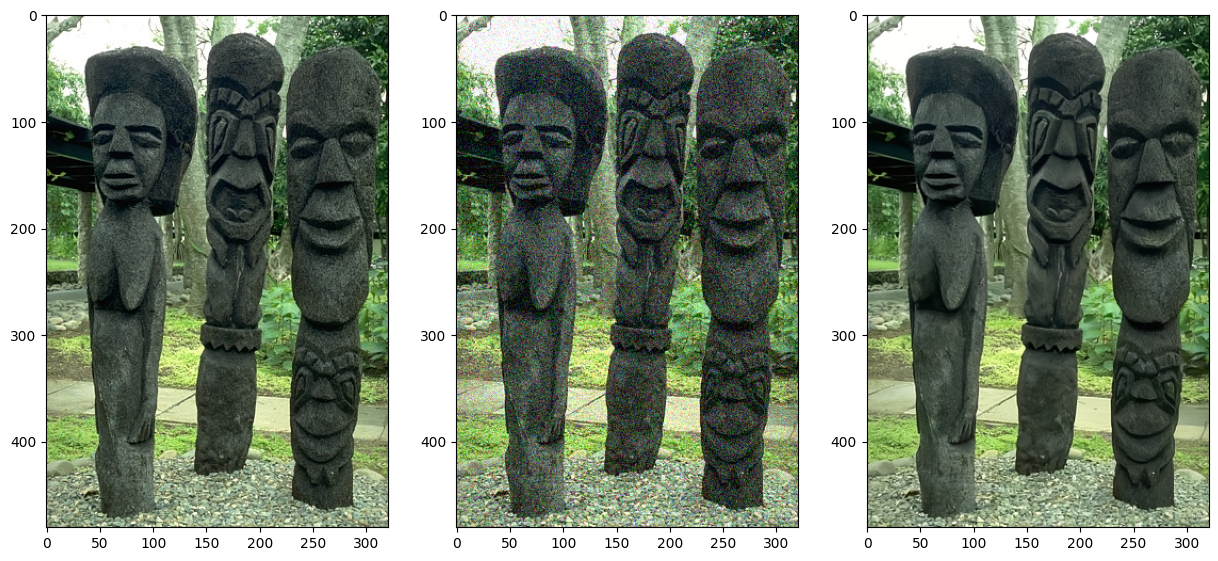

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

fromX, toX = (0, 1000)
fromY, toY = (0, 1000)

ax[0].imshow(img_true[fromX:toX, fromY:toY])
ax[1].imshow(noisy_img_raw[fromX:toX, fromY:toY])
ax[2].imshow(restored.astype(np.uint8)[fromX:toX, fromY:toY])

plt.show()

# 01

# 01

# 01

# 01

# 01

# 01

# 01

# 01

# 01

# 01

# END